<a href="https://colab.research.google.com/github/ShinyRyo/TPU/blob/master/Keras_Fashion_MNIST_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Fashion MNIST with Keras and TPUs

## Overview

In this example, you can try out using tf.keras and Cloud TPUs to train a model on the fashion MNIST dataset. The model trains for 10 epochs on Cloud TPU and takes approximately 2 minutes to run.

This notebook is hosted on GitHub. To view it in its original repository, after opening the notebook, select **File > View on GitHub**.

## Learning objectives

In this Colab, you will learn how to:
*   Code for a standard conv-net that has 3 layers with drop-out and batch normalization between each layer in Keras.
*   Create and compile the model under a distribution strategy in order ot use TPUs.
*   Run a prediction to see how well the model can predict fashion categories and output the result.

## Instructions

<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

TPUs are located in Google Cloud, for optimal performance, they read data directly from Google Cloud Storage (GCS)

## Data, model, and training

Begin by downloading the fashion MNIST dataset using `tf.keras.datasets`, as shown below.

In [0]:
import tensorflow as tf
import numpy as np

import distutils
if distutils.version.LooseVersion(tf.__version__) < '1.14':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Define the model

The following example uses a standard conv-net that has 3 layers with drop-out and batch normalization between each layer.

In [0]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

### Train on the TPU

To begin training, construct the model on the TPU and then compile it.

In [0]:
pip install tensorflow==1.14.0

In [0]:
import os

resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

with strategy.scope():
  model = create_model()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])

model.fit(
    x_train.astype(np.float32), y_train.astype(np.float32),
    epochs=17,
    steps_per_epoch=60,
    validation_data=(x_test.astype(np.float32), y_test.astype(np.float32)),
    validation_freq=17
)

model.save_weights('./fashion_mnist.h5', overwrite=True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system.
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.67.67.210:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 8194690827252680234)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7175165340481483891)
INFO:tensorflow:*** A

### Check the results (inference)

Now that you are done training, see how well the model can predict fashion categories!

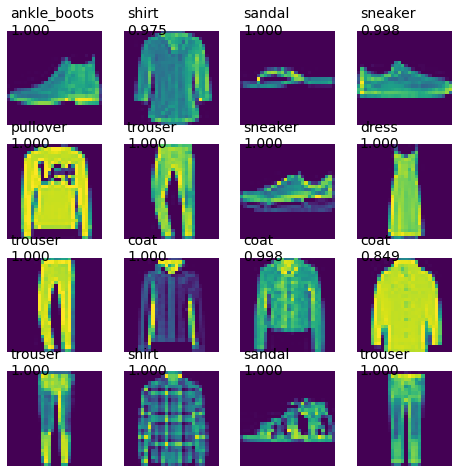

In [0]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


cpu_model = create_model()
cpu_model.load_weights('./fashion_mnist.h5')

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(x_test[:16]), 
                 cpu_model.predict(x_test[:16]))

## What's next

* Learn about [Cloud TPUs](https://cloud.google.com/tpu/docs) that Google designed and optimized specifically to speed up and scale up ML workloads for training and inference and to enable ML engineers and researchers to iterate more quickly.
* Explore the range of [Cloud TPU tutorials and Colabs](https://cloud.google.com/tpu/docs/tutorials) to find other examples that can be used when implementing your ML project.

On Google Cloud Platform, in addition to GPUs and TPUs available on pre-configured [deep learning VMs](https://cloud.google.com/deep-learning-vm/),  you will find [AutoML](https://cloud.google.com/automl/)*(beta)* for training custom models without writing code and [Cloud ML Engine](https://cloud.google.com/ml-engine/docs/) which will allows you to run parallel trainings and hyperparameter tuning of your custom models on powerful distributed hardware.
